In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

In [65]:
# Memuat dan memproses data
filename = 'data/data_balita.csv'
df = pd.read_csv(filename)

In [66]:
df.head()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


In [67]:
df.describe()

,Umur (bulan),Tinggi Badan (cm)
count,120999.000000,120999.000000
mean,30.173803,88.655434
std,17.575119,17.300997
min,0.000000,40.010437
25%,15.000000,77.000000
50%,30.000000,89.800000
75%,45.000000,101.200000
max,60.000000,128.000000


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [69]:
df.columns

Index(['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)', 'Status Gizi'], dtype='object')

In [70]:
unique_statuses = df['Status Gizi'].unique()
print(unique_statuses)

['stunted' 'tinggi' 'normal' 'severely stunted']


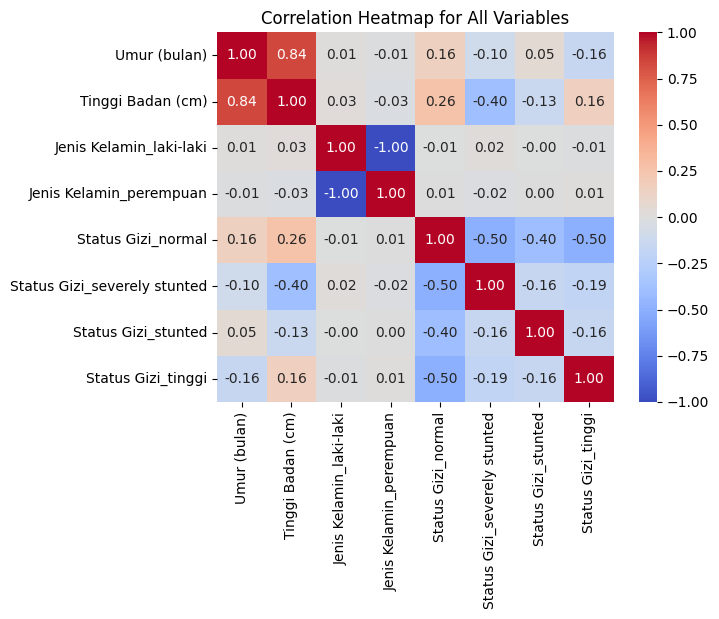

In [71]:
df_numerical = df.select_dtypes(include=['int64', 'float64'])

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df.select_dtypes(include=['object']))

# Concatenate numerical and encoded categorical variables
df_combined = pd.concat([df_numerical, df_encoded], axis=1)

# Create a heatmap for all variables
correlation_matrix_combined = df_combined.corr()
sns.heatmap(correlation_matrix_combined, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for All Variables')
plt.show()

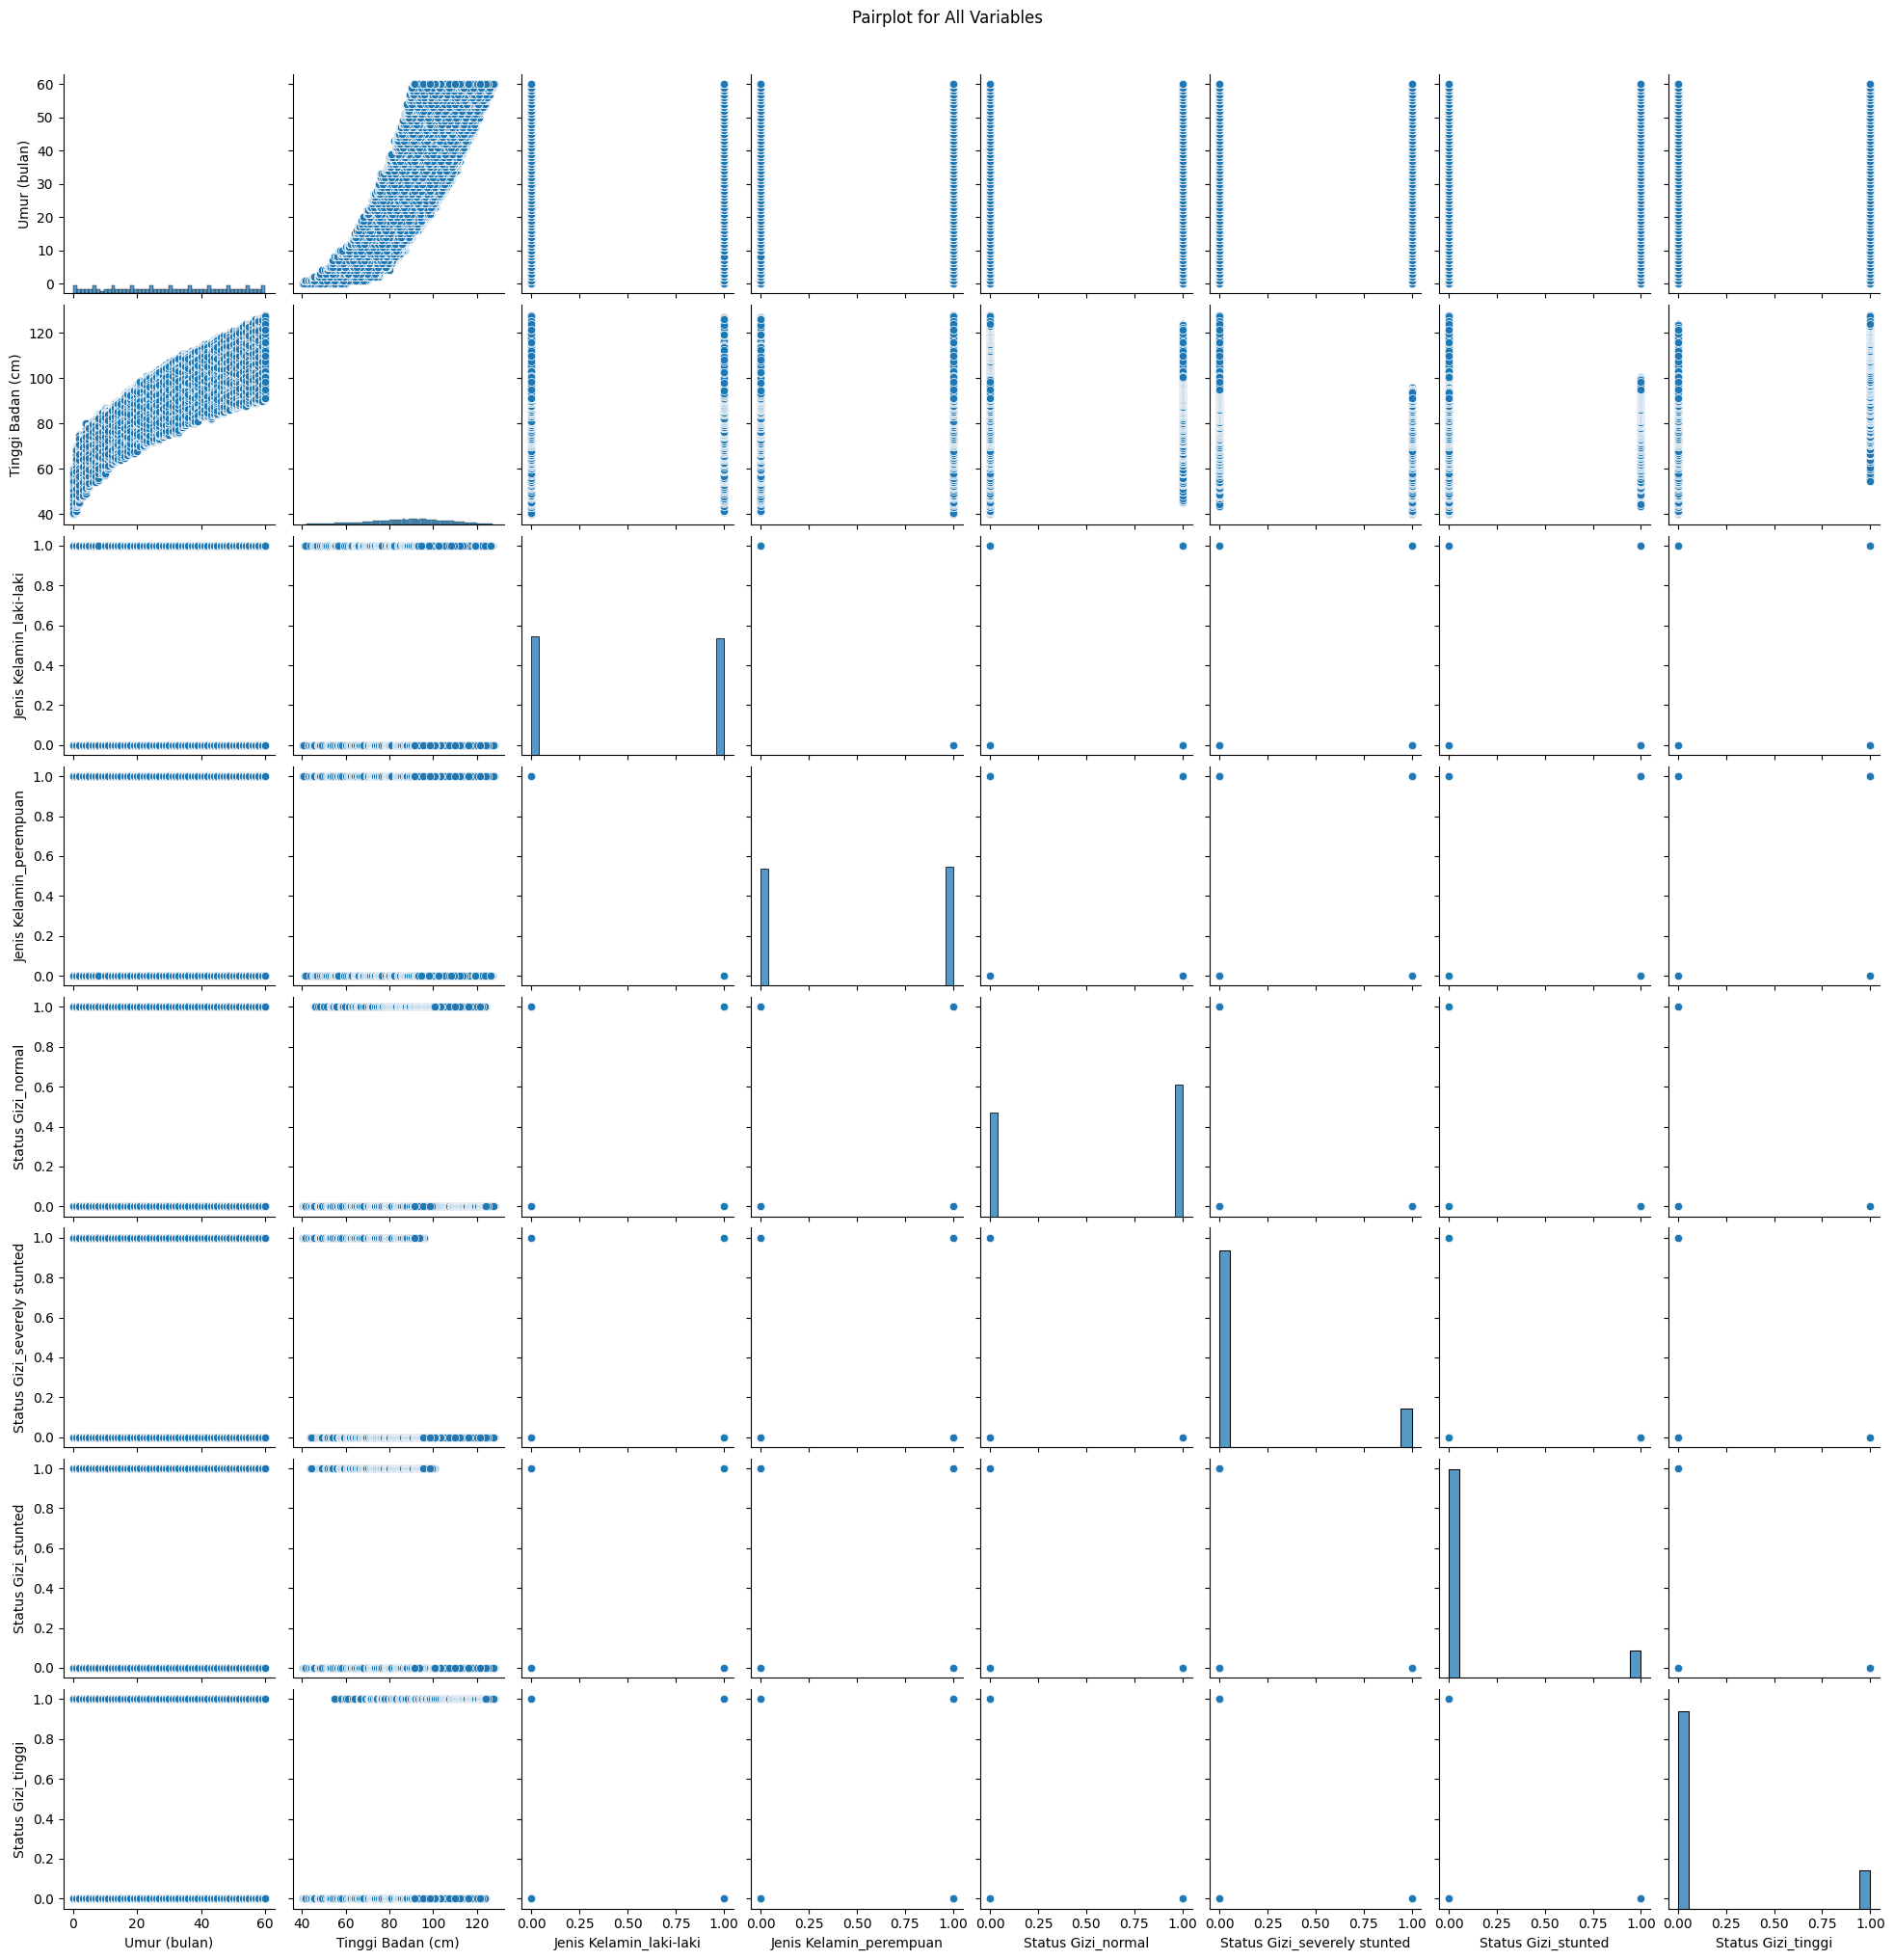

In [72]:
sns.pairplot(df_combined)
plt.suptitle('Pairplot for All Variables', y=1.02)
plt.show()

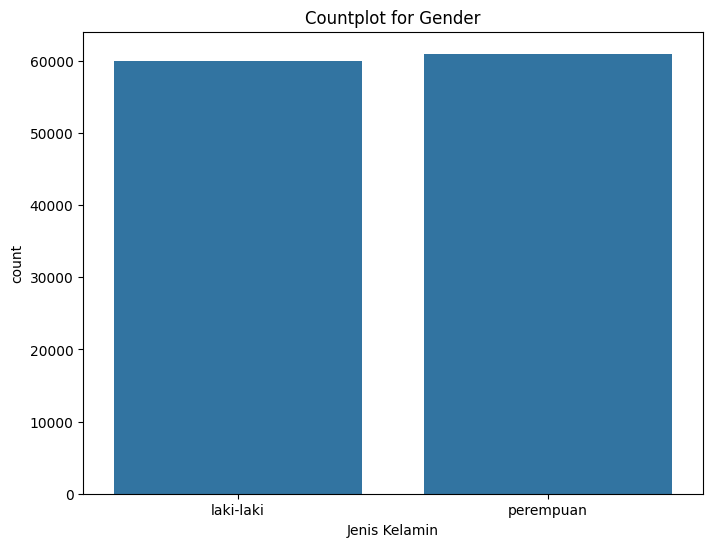

In [73]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Jenis Kelamin', data=df)
plt.title('Countplot for Gender')
plt.show()

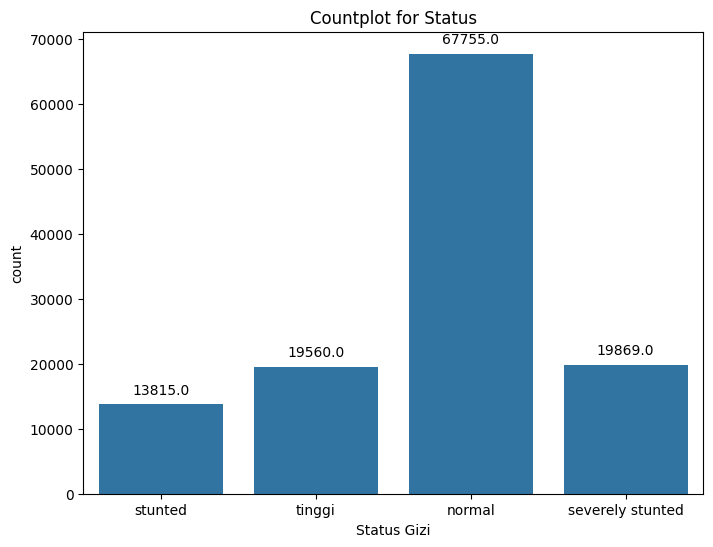

In [74]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Status Gizi', data=df)

# Add count annotations on the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Countplot for Status')
plt.show()

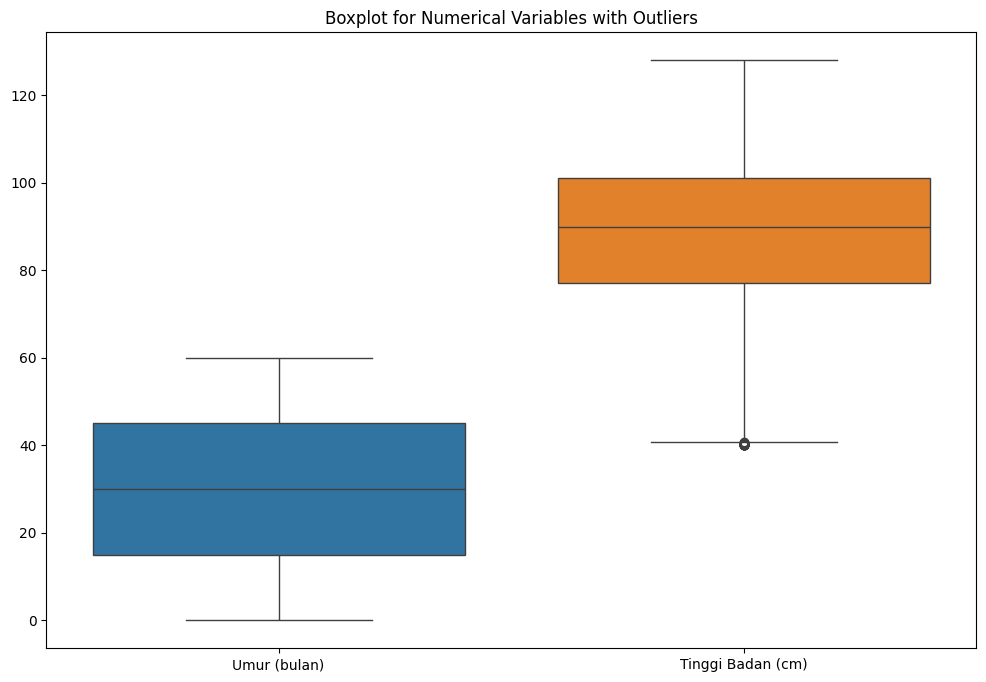

In [75]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_numerical, showfliers=True)
plt.title('Boxplot for Numerical Variables with Outliers')
plt.show()

In [76]:
X = df.drop('Status Gizi', axis=1)
y = df['Status Gizi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Use sparse_output instead of sparse
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# One-hot encode 'Jenis Kelamin' column
X_train_encoded[['Jenis Kelamin']] = encoder.fit_transform(X_train[['Jenis Kelamin']])
X_test_encoded[['Jenis Kelamin']] = encoder.transform(X_test[['Jenis Kelamin']])

# Label encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_encoded, y_train_encoded)

# Make predictions
y_pred_encoded = xgb_model.predict(X_test_encoded)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 99.10%

Classification Report:
                  precision    recall  f1-score   support

          normal       1.00      0.99      0.99     13382
severely stunted       0.99      0.99      0.99      4130
         stunted       0.97      0.98      0.97      2790
          tinggi       0.99      0.99      0.99      3898

        accuracy                           0.99     24200
       macro avg       0.99      0.99      0.99     24200
    weighted avg       0.99      0.99      0.99     24200


Confusion Matrix:
[[13295     0    39    48]
 [    0  4089    41     0]
 [   25    40  2725     0]
 [   24     0     0  3874]]


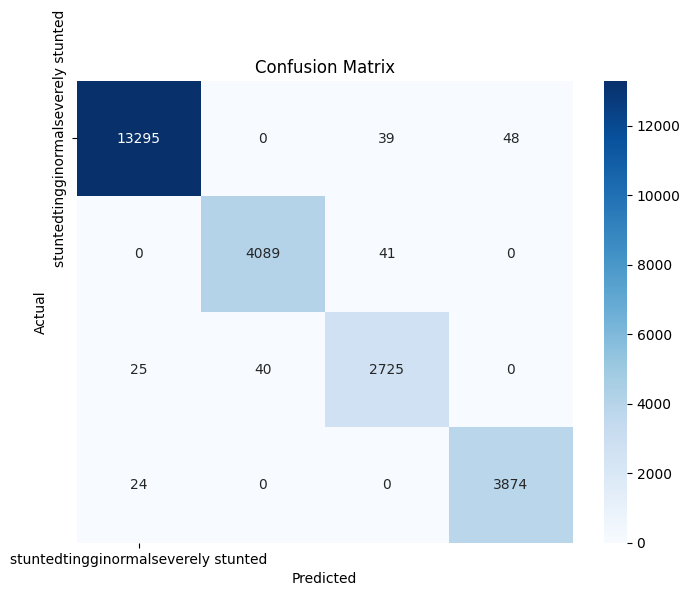

In [78]:
cm = confusion_matrix(y_test, y_pred)
labels = ['stunted' 'tinggi' 'normal' 'severely stunted']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()